In [1]:
import pandas as pd
import random
import dgl
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from dgllife.model import model_zoo
from dgllife.utils import smiles_to_bigraph
from dgllife.utils import EarlyStopping, Meter
from dgllife.utils import AttentiveFPAtomFeaturizer
from dgllife.utils import AttentiveFPBondFeaturizer

import torch
import os
import random
import numpy as np
import ast

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import SVG, display
from rdkit.Chem import rdDepictor
from rdkit.Chem.Draw import rdMolDraw2D

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import pickle
import argparse
from rdkit import RDLogger 
import warnings
warnings.filterwarnings("ignore")
RDLogger.DisableLog('rdApp.*') # switch off RDKit warning messages

In [2]:
from utils import get_values_at_positions, atom_finder, smiles_augmentation, concat_feature_reactive_atom, collate_molgraphs, Canon_SMILES_similarity
from model import AttentiveFPPredictor_rxn, weighted_binary_cross_entropy

In [3]:
atom_featurizer = AttentiveFPAtomFeaturizer(atom_data_field='hv')
bond_featurizer = AttentiveFPBondFeaturizer(bond_data_field='he')
n_feats = atom_featurizer.feat_size('hv')
e_feats = bond_featurizer.feat_size('he')
print( 'Number of features in graph : ' , n_feats)

Number of features in graph :  39


In [4]:
device = torch.device('cuda:0' if torch.cuda.is_available() else "cpu")

In [5]:
# Modify the model to fit your classification task
model = AttentiveFPPredictor_rxn(node_feat_size=n_feats,
                                   edge_feat_size=e_feats,
                                   num_layers=2,
                                   num_timesteps=1,
                                   graph_feat_size=200,
                                   n_tasks=8,
                                   dropout=0.1
                                    )


In [6]:
fn = 'final_trained_ReactAIvate_model'

In [7]:
model.load_state_dict(torch.load(fn))
gcn_net = model.to(device)

In [8]:
#oxidative addition mechanism
def ox_addition_template_select(mol):
    if mol.GetSubstructMatch(Chem.MolFromSmarts('[#6][I:1]')):
        ox_addition_temp = '[Mg,Fe,Ni,Cu,Pd,Pt:2].[*:3][I:1]>>[Mg,Fe,Ni,Cu,Pd,Pt:2]([I:1])[*:3]'
    elif mol.GetSubstructMatch(Chem.MolFromSmarts('[#6][Br:1]')):
        ox_addition_temp = '[Mg,Fe,Ni,Cu,Pd,Pt:2].[*:3][Br:1]>>[Mg,Fe,Ni,Cu,Pd,Pt:2]([Br:1])[*:3]'
    elif mol.GetSubstructMatch(Chem.MolFromSmarts('[#6][Cl:1]')):
        ox_addition_temp = '[Mg,Fe,Ni,Cu,Pd,Pt:2].[*:3][Cl:1]>>[Mg,Fe,Ni,Cu,Pd,Pt:2]([Cl:1])[*:3]'
    elif mol.GetSubstructMatch(Chem.MolFromSmarts('[#6][F:1]')):
        ox_addition_temp = '[Mg,Fe,Ni,Cu,Pd,Pt:2].[*:3][F:1]>>[Mg,Fe,Ni,Cu,Pd,Pt:2]([F:1])[*:3]'
    ox_addition = AllChem.ReactionFromSmarts(ox_addition_temp)
    return ox_addition


#reductive elimination mechanism
reductive_elimination_template = '[#6:1][Mg,Fe,Ni,Cu,Pd,Pt:2][#6,#7:3]>>[#6:1][#6,#7:3].[Mg,Fe,Ni,Cu,Pd,Pt:2]'
reductive_elimination = AllChem.ReactionFromSmarts(reductive_elimination_template)

#transmetallation
transmetallation_template = '[Mg,Fe,Ni,Cu,Pd,Pt:1][F,Cl,Br,I:2].[#6:5][B:3]>>[Mg,Fe,Ni,Cu,Pd,Pt:1][#6:5].[F,Cl,Br,I:2][B:3]'
trans_metalation = AllChem.ReactionFromSmarts(transmetallation_template)

#MI_kumada
MI_template_kumada = '[Mg,Fe,Ni,Cu,Pd,Pt:1][F,Cl,Br,I:2].[#6:5][Mg,Fe:3]>>[Mg,Fe,Ni,Cu,Pd,Pt:1][#6:5].[F,Cl,Br,I:2][Mg,Fe:3]'
MI_kumada = AllChem.ReactionFromSmarts(MI_template_kumada)


#Boronate
boronate_template = '[Na,K,Rb,Cs:1][O:2].[#6:3][B:4]>>[O:2][B-:4][#6:3].[Na+,K+,Rb+,Cs+:1]'
boronate = AllChem.ReactionFromSmarts(boronate_template)

#amine addition
am_add_template = '[Pd:1].[N;!H0:2]>>[Pd:1][N+:2]'
am_add=AllChem.ReactionFromSmarts(am_add_template)


#acid_base deprotonation
ac_ba_template = '[N:5][Mg,Fe,Ni,Cu,Pd,Pt:3][F,Cl,Br,I:4].[Na,K,Rb,Cs:1][O:2]>>[Na,K,Rb,Cs:1][F,Cl,Br,I:4].[0:2].[N:5][Mg,Fe,Ni,Cu,Pd,Pt:3]'
ac_ba = AllChem.ReactionFromSmarts(ac_ba_template)

def neutralize_atoms(mol):
    pattern = Chem.MolFromSmarts("[+1!h0!$([*]~[-1,-2,-3,-4]),-1!$([*]~[+1,+2,+3,+4])]")
    at_matches = mol.GetSubstructMatches(pattern)
    at_matches_list = [y[0] for y in at_matches]
    if len(at_matches_list) > 0:
        for at_idx in at_matches_list:
            atom = mol.GetAtomWithIdx(at_idx)
            chg = atom.GetFormalCharge()
            hcount = atom.GetTotalNumHs()
            atom.SetFormalCharge(0)
            atom.SetNumExplicitHs(hcount - chg)
            atom.UpdatePropertyCache()
    return mol

In [9]:
index_to_label = {0:'oxidative_addition',
1:'boronate_formation',
2:'boron transmetallation',    
3:'reductive_elemination',
4:'amine_coordination',
5:'acid_base_deprotonation',                  
6:'transmetallation',
7:'ood'} 


def CRM_path(reaction_path, predicted_class):

    if predicted_class == 0:
        # Oxidative Addition
        reactants  = reaction_path.split('.')
        sub1 = reactants[0]
        sub2 = reactants[1]
        mol1 = Chem.MolFromSmiles(sub1)
        mol2 = Chem.MolFromSmiles(sub2)
        try:  
            ox_addition_template = ox_addition_template_select(mol2)
            ox_add_mol = ox_addition_template.RunReactants((mol1, mol2))
            ox_add_sm = Chem.MolToSmiles(ox_add_mol[0][0])  # Oxidative addition pdt

            if len(reactants)==3:
                ox_add_pdt = '.'.join([ox_add_sm, reactants[2]])
                return ox_add_pdt
            elif len(reactants)==4:
                ox_add_pdt = '.'.join([ox_add_sm, reactants[2], reactants[3]])
                return ox_add_pdt
        except:
            return 'CCCCCC.CCCCCC.CCCCCC'

    if predicted_class == 4:
        # Amine coordination
        reactants  = reaction_path.split('.')
        sub1 = reactants[0]
        sub2 = reactants[1]
        try: 
            mol1 = Chem.MolFromSmiles(sub1)
            mol2 = Chem.MolFromSmiles(sub2)
            am_add_mol = am_add.RunReactants((mol1, mol2))
            am_add_sm0 =  Chem.MolToSmiles(am_add_mol[0][0]) #amine addition product
            am_add_pdt = '.'.join([am_add_sm0, reactants[2]])   
            return am_add_pdt
        except:
            return 'CCCCCC.CCCCCC.CCCCCC'
        
    if predicted_class == 5:
       #deprotonation, #acid_base deprotonation
        reactants  = reaction_path.split('.')
        sub1 = reactants[0]
        sub2 = reactants[1]
        mol1 = Chem.MolFromSmiles(sub1)
        mol2 = Chem.MolFromSmiles(sub2)        
        
        try: 
            neut_am_mol = neutralize_atoms(mol1)
            neut_am_sm = Chem.MolToSmiles(neut_am_mol) #neutralized amine

            ac_ba_mol = ac_ba.RunReactants((neut_am_mol, mol2)) #halogen transfered to alkali metal
            ac_ba_sm0 =  Chem.MolToSmiles(ac_ba_mol[0][0])
            ac_ba_sm1 =  Chem.MolToSmiles(ac_ba_mol[0][1])
            ac_ba_sm2 =  Chem.MolToSmiles(ac_ba_mol[0][2])
            ac_ba_pdt = '.'.join([ac_ba_sm2, ac_ba_sm0, ac_ba_sm1])      
            return ac_ba_pdt
        except:
            return 'CCCCCC.CCCCCC.CCCCCC'
        
    if predicted_class == 3:
        #reductive elimination
        reactants  = reaction_path.split('.')
        sub1 = reactants[0]
        mol1 = Chem.MolFromSmiles(sub1)     
        try: 
            red_eli_mol = reductive_elimination.RunReactants((mol1, ))
            red_eli_sm0 = Chem.MolToSmiles(red_eli_mol[0][0])
            red_eli_sm1 = Chem.MolToSmiles(red_eli_mol[0][1])

            if len(reactants)==2:
                red_eli_pdt = '.'.join([red_eli_sm1, red_eli_sm0, reactants[1]])
                return red_eli_pdt
            elif len(reactants)==3:
                red_eli_pdt = '.'.join([red_eli_sm1, red_eli_sm0,  reactants[1], reactants[2]])  
                return red_eli_pdt
        except:
            return 'CCCCCC.CCCCCC.CCCCCC'
        
    if predicted_class == 2:
        # boron transmetallation
        reactants  = reaction_path.split('.')
        sub1 = reactants[0]
        sub2 = reactants[1]
        mol1 = Chem.MolFromSmiles(sub1)
        mol2 = Chem.MolFromSmiles(sub2)           
        try: 
            tr_met_mol = trans_metalation.RunReactants((mol1, mol2))
            tr_met_sm0 =  Chem.MolToSmiles(tr_met_mol[0][0])
            tr_met_sm1 =  Chem.MolToSmiles(tr_met_mol[0][1])
            if len(reactants)==2:
                tr_met_pdt = '.'.join([tr_met_sm0, tr_met_sm1]) 
                return tr_met_pdt
            elif len(reactants)==3:
                tr_met_pdt = '.'.join([tr_met_sm0, tr_met_sm1, reactants[2]]) 
                return tr_met_pdt
        except:
            return 'CCCCCC.CCCCCC.CCCCCC'        
    if predicted_class == 1:

        try:    
            # Only Boronate step
            reactants  = reaction_path.split('.')
            sub2 = reactants[1]
            sub3 = reactants[2]
            mol2 = Chem.MolFromSmiles(sub2)
            mol3 = Chem.MolFromSmiles(sub3)
            
            br_met_mol = boronate.RunReactants((mol3, mol2))
            br_met_sm0 = Chem.MolToSmiles(br_met_mol[0][0])  # Boronate
            br_met_sm1 = Chem.MolToSmiles(br_met_mol[0][1])  # Metal ion
            br_met_pdt = '.'.join([reactants[0],br_met_sm0, br_met_sm1])
            return br_met_pdt
        except:
            return 'CCCCCC.CCCCCC.CCCCCC'
        
    if predicted_class == 6:
        #transmetallation
        reactants  = reaction_path.split('.')
        sub1 = reactants[0]
        sub2 = reactants[1]
        #sub3 = reactants[2]
        mol1 = Chem.MolFromSmiles(sub1)
        mol2 = Chem.MolFromSmiles(sub2) 
        #mol3 = Chem.MolFromSmiles(sub3)
        
        try:
            tr_met_mol = MI_kumada.RunReactants((mol1, mol2))
            tr_met_sm0 =  Chem.MolToSmiles(tr_met_mol[0][0])
            tr_met_sm1 =  Chem.MolToSmiles(tr_met_mol[0][1])
            if len(reactants)==2:
                tr_met_pdt = '.'.join([tr_met_sm0, tr_met_sm1]) 
                return tr_met_pdt
        except:
            return 'CCCCCC.CCCCCC.CCCCCC'
    if predicted_class == 7:
        return reaction_path  

In [10]:
def prediction_with_attention(smiles,trained_model, out_file_name):
    g = smiles_to_bigraph(smiles, node_featurizer=atom_featurizer,edge_featurizer=bond_featurizer, canonical_atom_order=False)
    g = dgl.batch([g]).to(device)    
    atom_feats, bond_feats = g.ndata.pop('hv').to(device), g.edata.pop('he').to(device)
    class_label_p,  atom_weights , reactive_atom_label_p, graph_feat= trained_model(g, atom_feats, bond_feats, get_node_weight=True)
    class_label_p = class_label_p.cpu().argmax(dim=1).numpy()

    #print(class_label_p)
    print('Predicted elementary step: ', index_to_label[class_label_p[0]])
    
    y_pred_node = reactive_atom_label_p.detach().cpu().numpy()
    
    threshold = 0.5
    # Convert predicted probabilities to binary values
    y_pred_binary = [1 if pred >= threshold else 0 for pred in y_pred_node]
    y_pred_binary = [index for index, value in enumerate(y_pred_binary) if value == 1]
    print('Predicted reactive atom: ', y_pred_binary)
    
    #Attention visualization
    atom_weights = atom_weights[0]
    min_value = torch.min(atom_weights)
    max_value = torch.max(atom_weights)
    atom_weights = (atom_weights - min_value) / (max_value - min_value)    
    c=atom_weights.detach().cpu().numpy().flatten().tolist()
    norm = matplotlib.colors.Normalize(vmin=0,vmax=(sum(c)/len(c)))
    cmap = cm.get_cmap('Reds')
    plt_colors = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    atom_colors = {i: plt_colors.to_rgba(atom_weights[i].data.item()) for i in range(g.number_of_nodes())}
    plt_colors._A = [] 
    #cb = plt.colorbar(plt_colors) 
    #cb.set_ticks([])    

    mol = Chem.MolFromSmiles(smiles)
    rdDepictor.Compute2DCoords(mol)
    drawer = rdMolDraw2D.MolDraw2DSVG(600,600)
    
    drawer.SetFontSize(5)
    op = drawer.drawOptions().addAtomIndices=True
    
    mol = rdMolDraw2D.PrepareMolForDrawing(mol)
    drawer.DrawMolecule(mol,highlightAtoms=range(g.number_of_nodes()),highlightBonds=[],
    highlightAtomColors=atom_colors)
    drawer.FinishDrawing()
    svg = drawer.GetDrawingText()
    svg = svg.replace('svg:','')

    # Save SVG to a file instead of displaying it
    with open(out_file_name, 'w') as f:
        f.write(svg)

    display(SVG(svg))

    return smiles, class_label_p, y_pred_binary

In [11]:
# Provide smiles string for your target SMILES
# As templates are sensitive to order of reactants. The expected order is catalyst.aryl_halide.boronic_acid/amine/grignard_reagent.base

smiles_check  = 'CC(C)(C)[P+]([Pd])(c1ccccc1-c1ccccc1)C(C)(C)C.Clc1ccccn1.OB(O)c1cccc2ccccc12.[Cs]O'


Predicted elementary step:  oxidative_addition
Predicted reactive atom:  [5, 22, 23, 30, 32, 42, 43]


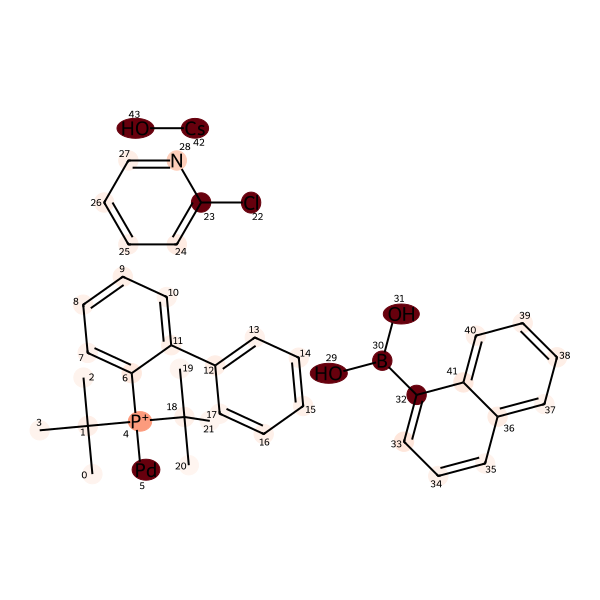

Predicted elementary step:  boronate_formation
Predicted reactive atom:  [17, 18, 30, 32, 42, 43]


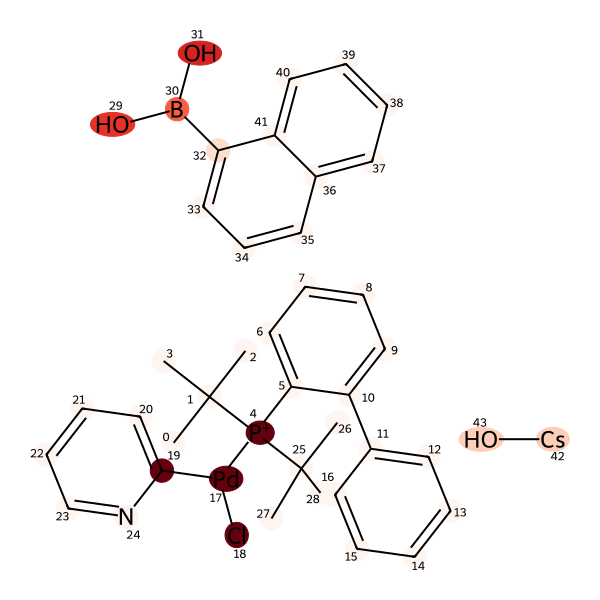

Predicted elementary step:  boron transmetallation
Predicted reactive atom:  [17, 18, 30, 33]


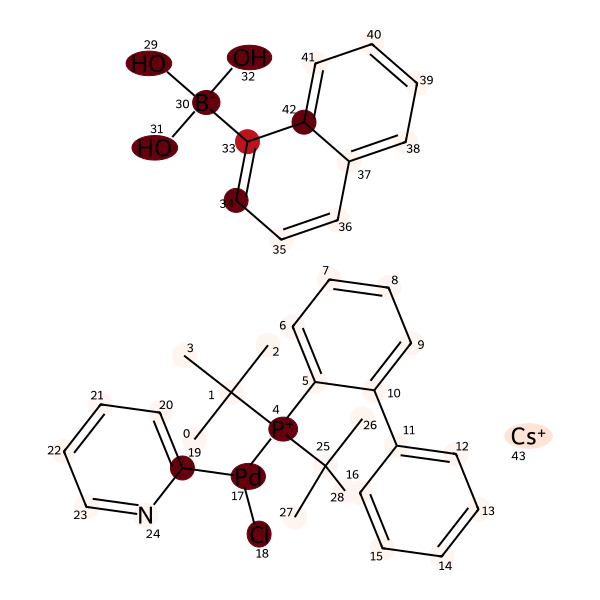

Predicted elementary step:  reductive_elemination
Predicted reactive atom:  [17, 18, 24]


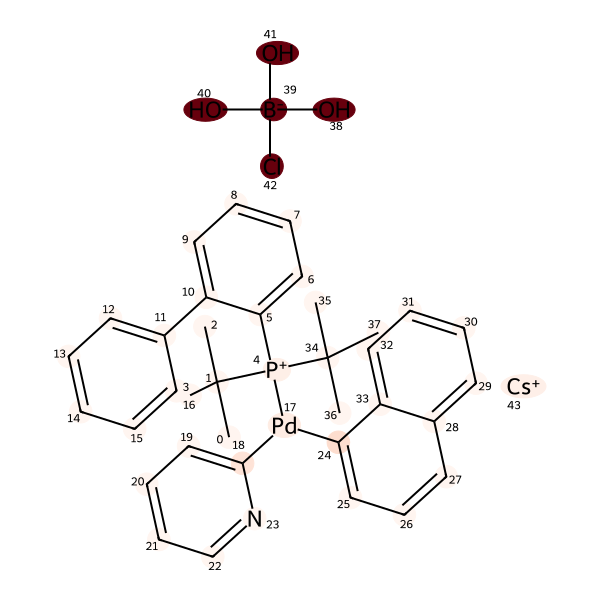

In [12]:
CRM_smiles = []
CRM_class = []
CRM_reactive_atoms = []
reacting_prefix = smiles_check.split('.')[0]
for i in range(4):
    output_file_name = 'elementary_step_smc' + str(i) + '.svg'
    ES_smiles, predicted_class, reactive_atoms = prediction_with_attention(smiles_check, gcn_net, output_file_name)
    CRM_class.append(predicted_class)
    CRM_reactive_atoms.append(reactive_atoms)
    smiles_check1 = CRM_path(ES_smiles, predicted_class)
    CRM_smiles.append(smiles_check1)
    smiles_check_prefix = smiles_check1.split('.')[0]
    smiles_check = smiles_check1
    if Chem.MolToSmiles(Chem.MolFromSmiles(reacting_prefix)) == Chem.MolToSmiles(Chem.MolFromSmiles(smiles_check_prefix)):
        break


In [13]:
CRM_smiles

['CC(C)(C)[P+](c1ccccc1-c1ccccc1)([Pd]([Cl])[c]1ccccn1)C(C)(C)C.OB(O)c1cccc2ccccc12.[Cs]O',
 'CC(C)(C)[P+](c1ccccc1-c1ccccc1)([Pd]([Cl])[c]1ccccn1)C(C)(C)C.O[B-](O)(O)c1cccc2ccccc12.[Cs+]',
 'CC(C)(C)[P+](c1ccccc1-c1ccccc1)([Pd]([c]1ccccn1)[c]1cccc2ccccc12)C(C)(C)C.O[B-](O)(O)Cl.[Cs+]',
 'CC(C)(C)[P+]([Pd])(c1ccccc1-c1ccccc1)C(C)(C)C.c1ccc(-c2cccc3ccccc23)nc1.O[B-](O)(O)Cl.[Cs+]']

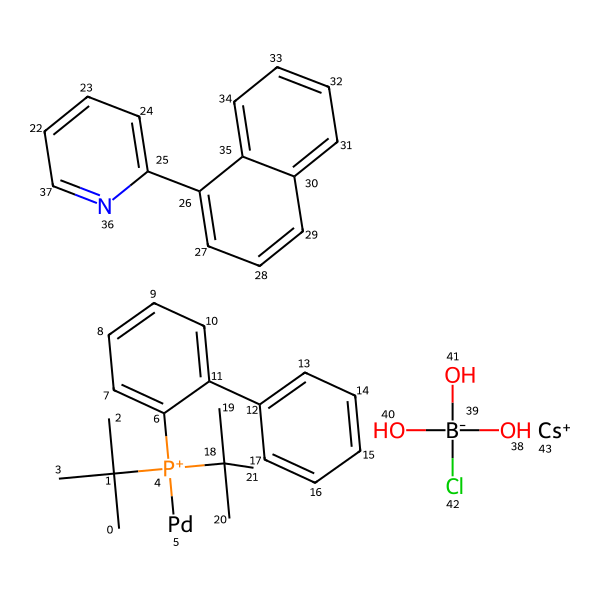

In [14]:
mol = Chem.MolFromSmiles(CRM_smiles[-1])
rdDepictor.Compute2DCoords(mol)
drawer = rdMolDraw2D.MolDraw2DSVG(600,600)

drawer.SetFontSize(5)
op = drawer.drawOptions().addAtomIndices=True

mol = rdMolDraw2D.PrepareMolForDrawing(mol)
drawer.DrawMolecule(mol)
drawer.FinishDrawing()
svg = drawer.GetDrawingText()
svg = svg.replace('svg:','')

# Save SVG to a file instead of displaying it
with open('pdt_smc.svg', 'w') as f:
    f.write(svg)

display(SVG(svg))